In [115]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import contractions


In [129]:
# Read the CSV file
x_train = pd.read_csv('../data/x_train.csv')
x_valid = pd.read_csv('../data/x_valid.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_valid = pd.read_csv('../data/y_valid.csv')


In [130]:
x_train = x_train.drop(['ID', 'Date', 'flag', 'User'], axis = 'columns')
x_train['Target'] = x_train['Target'].replace(4, 1)
x_train['Text'] = x_train['Text'].replace(r"@\w+", "", regex=True)
x_train['Text'] = x_train['Text'].apply(lambda x: contractions.fix(x))
x_train['Text'] = x_train['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
x_train['Text'] = x_train['Text'].apply(lambda x: re.sub(r'http\S+', '', x))
x_train['Text'] = x_train['Text'].str.lower()
x_train['Text'] = x_train["Text"].apply(lambda x: " ".join([w for w in x.split() if len(w)>=2]))
tokenized_tweet = x_train['Text'].apply(lambda x: x.split())
wnl = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos="v") for word in s]) # lemmatization
combined_sentences = [' '.join(tokens) for tokens in tokenized_tweet]
x_train['Text'] = combined_sentences
bow_vectorizer = CountVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words='english')
bow = bow_vectorizer.fit_transform(x_train['Text'])


In [131]:
x_valid = x_valid.drop(['ID', 'Date', 'flag', 'User'], axis = 'columns')
x_valid['Target'] = x_valid['Target'].replace(4, 1)
x_valid['Text'] = x_valid['Text'].replace(r"@\w+", "", regex=True)
x_valid['Text'] = x_valid['Text'].apply(lambda x: contractions.fix(x))
x_valid['Text'] = x_valid['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
x_valid['Text'] = x_valid['Text'].apply(lambda x: re.sub(r'http\S+', '', x))
x_valid['Text'] = x_valid['Text'].str.lower()
x_valid['Text'] = x_valid["Text"].apply(lambda x: " ".join([w for w in x.split() if len(w)>=2]))
tokenized_tweet = x_valid['Text'].apply(lambda x: x.split())
wnl = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos="v") for word in s]) # lemmatization
combined_sentences = [' '.join(tokens) for tokens in tokenized_tweet]
x_valid['Text'] = combined_sentences
bow_vectorizer = CountVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words='english')
bow = bow_vectorizer.fit_transform(x_valid['Text'])

In [132]:
x_valid

,Target,Text
0,0,tierd and it be school tomorrow last week atleast
1,0,twitter get bore bore everydayno star want rep...
2,1,be watch guy ripley right nowhahahilarious
3,0,that be the way indoor stadium toilets be
4,1,it must be all that bike rid
...,...,...
220196,0,wantd 2b comedian when lil boy memrize commerc...
220197,0,omg cannot believe jay leno be go off the air
220198,0,do not know my days be all mess up since get o...
220199,0,so be guessin mean midnight pacific time


In [133]:
training_sentences = x_train['Text'].tolist()
testing_sentences = x_valid['Text'].tolist()


In [134]:
training_labels = x_train['Target'].tolist()
testing_labels = x_valid['Target'].tolist()


In [137]:
vocab_size = 100000
oov_tok = "<OOV>"
max_length = 120

In [138]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_length, 
                                padding = 'post',
                                truncating = 'post')

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, 
                                maxlen = max_length,
                                padding = 'post',
                                truncating = 'post')


In [139]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [141]:
training_labels.shape, training_padded.shape, testing_labels.shape, testing_padded.shape

((513801,), (513801, 120), (220201,), (220201, 120))

In [142]:
embedding_dim = 16


In [144]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [145]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [146]:
num_epochs = 30

In [147]:
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, 
                                     testing_labels), 
                    verbose=2)

Epoch 1/30
16057/16057 - 281s - 17ms/step - accuracy: 0.8126 - loss: 0.4277 - val_accuracy: 0.8423 - val_loss: 0.3759
Epoch 2/30
16057/16057 - 249s - 16ms/step - accuracy: 0.8378 - loss: 0.3758 - val_accuracy: 0.8267 - val_loss: 0.3828
Epoch 3/30
16057/16057 - 245s - 15ms/step - accuracy: 0.8447 - loss: 0.3616 - val_accuracy: 0.8486 - val_loss: 0.3551
Epoch 4/30
16057/16057 - 261s - 16ms/step - accuracy: 0.8481 - loss: 0.3549 - val_accuracy: 0.8426 - val_loss: 0.3604
Epoch 5/30
16057/16057 - 313s - 20ms/step - accuracy: 0.8507 - loss: 0.3489 - val_accuracy: 0.8386 - val_loss: 0.3674
Epoch 6/30
16057/16057 - 279s - 17ms/step - accuracy: 0.8541 - loss: 0.3425 - val_accuracy: 0.8502 - val_loss: 0.3558
Epoch 7/30
16057/16057 - 285s - 18ms/step - accuracy: 0.8560 - loss: 0.3382 - val_accuracy: 0.8484 - val_loss: 0.3525
Epoch 8/30
16057/16057 - 304s - 19ms/step - accuracy: 0.8574 - loss: 0.3351 - val_accuracy: 0.8512 - val_loss: 0.3507
Epoch 9/30
16057/16057 - 285s - 18ms/step - accuracy: 0.

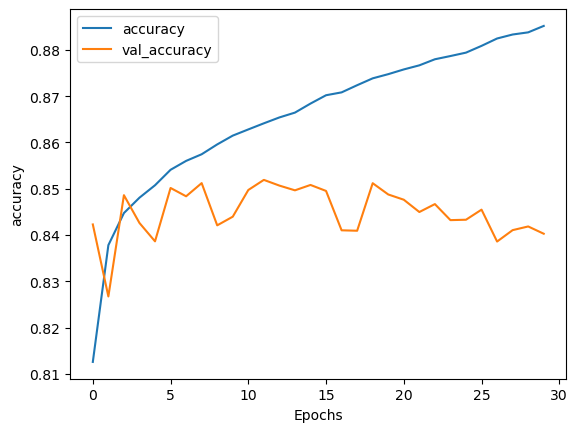

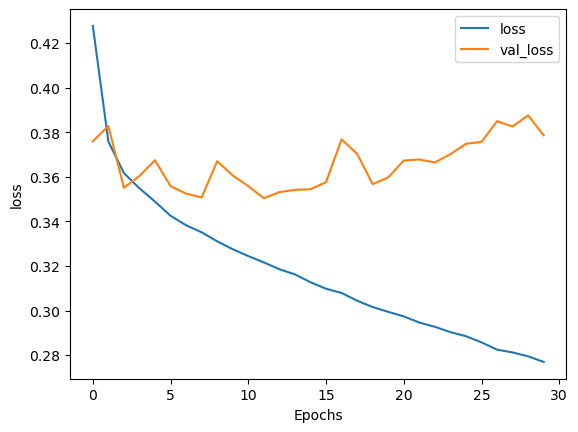

In [148]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")